In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# Import Meteostat library and dependencies
from datetime import datetime,timedelta
from meteostat import Hourly, Stations
from scipy.interpolate import UnivariateSpline


import solarpy as sp


In [14]:
# Set time period
n_days = 3 #set how many days must be simulated 

#Set start date 
# Warmest day = 8,7,2023
# Ice day: 13-12-2022 (ampbient temp < 0 degrees C) https://www.knmi.nl/nederland-nu/klimatologie/maand-en-seizoensoverzichten/2022/december#:~:text=Koud%20tot%20en%20met%2018,dagen%20het%20hele%20etmaal%20vriezen.
# Shortest day = 21-12-20xx
start_day = 8
start_month= 7
start_year= 2023

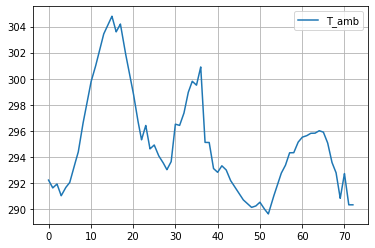

In [15]:
#Import weather data and extract temperature and pressure

# Get nearby weather stations
stations = Stations()
lat = 52.36
lon = 4.94

#statins = stations.nearby(52.35660593196212, 4.948958216497039)
stations = stations.nearby(lat, lon)
station = stations.fetch(1)

# Print DataFrame
#print(station)

# Set time period
start1 = datetime(start_year, start_month, start_day)
end1 = start1 + timedelta(days=n_days)

# Get hourly data
data_warm = Hourly(station, start1, end1)
data_warm = data_warm.fetch()

# Create an array for each hour in the day, converted to seconds
dt=1 # Second
day_length = n_days*24 * 60 * 60  # length of a day in seconds
time_steps = np.linspace(0, day_length, num=day_length // dt + n_days)  # time steps
hours = np.arange(n_days*24)*60*60

# Interpolate the temperature data to a per-second basis
T_amb = np.interp(time_steps, hours, data_warm['temp'][0:len(hours)].values+273) #[K] 
P_amb = np.interp(time_steps, hours, data_warm['pres'][0:len(hours)].values*100) #Ambient pressure in [pa]
v_wind = (data_warm['wspd'][0:len(hours)]*3.6*(0.1/2))**(1/7) #Wind speed in m/s 0,1 meter above the ground
v_wind_int = np.interp(time_steps, hours, v_wind) #Ambient pressure in [pa]

# Plot the data
plt.plot(time_steps/3600, T_amb,label='T_amb')
plt.grid()
plt.legend()
plt.show()


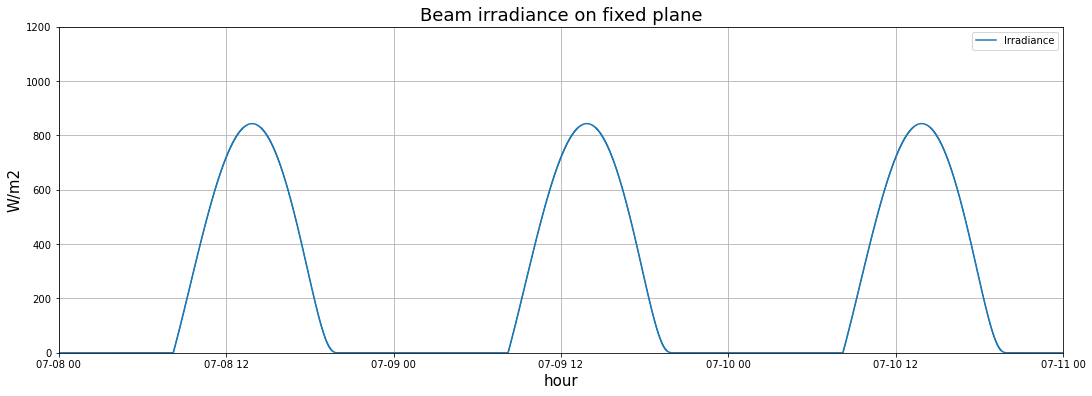

In [17]:
#Extract solar intensity data 

def plot_irradiance(n_days, start_day, lat=lat, vnorm=np.array([-1, -1, -1])): #vnorm is a vector facing south 
    fig, ax = plt.subplots(figsize=(18, 6))
    
    all_t = np.array([])
    all_G = np.array([])
    
    for n in range(n_days):
        #Extract the intensity for a day
        delta_t = start_day + timedelta(days=n)
        t = np.array([delta_t + timedelta(seconds=i) for i in range(0, 24 * 60*60+1, 1)])  # One data point per second
        G = np.array([sp.irradiance_on_plane(vnorm, 0, i, lat) for i in t])

        #Append it to make it one vector of multiple days
        all_t = np.concatenate((all_t, t)) #Concentate is the np equivallent of append
        all_G = np.concatenate((all_G, G))

    plt.plot(all_t, all_G, label='Irradiance')

    plt.autoscale(enable=True, axis='x', tight=True)
    plt.ylim(0, 1200)
    plt.xlabel('hour', fontsize=15)
    plt.ylabel('W/m2', fontsize=15)
    plt.title('Beam irradiance on fixed plane', fontsize=18)
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return all_G  # Return the array of irradiance values

# Use the function and store the result
solar_constants = plot_irradiance(n_days, start1)

In [18]:

df = pd.DataFrame({
    't': time_steps[:len(T_amb)],
'T_amb': T_amb,
'P_amb': P_amb,
'v_wind': v_wind_int,
'P_sun': solar_constants
})

df

,t,T_amb,P_amb,v_wind,P_sun
0,0.000000,292.200000,101790.000000,1.141151,0.0
1,0.999992,292.199833,101789.988889,1.141151,0.0
2,1.999985,292.199667,101789.977778,1.141151,0.0
3,2.999977,292.199500,101789.966667,1.141151,0.0
4,3.999969,292.199333,101789.955556,1.141151,0.0
...,...,...,...,...,...
259198,259196.000031,290.300000,101760.000000,1.033567,0.0
259199,259197.000023,290.300000,101760.000000,1.033567,0.0
259200,259198.000015,290.300000,101760.000000,1.033567,0.0
259201,259199.000008,290.300000,101760.000000,1.033567,0.0


In [19]:
df.to_csv('Meteo_data\Weather_data_{}_{}_{}_n{}.csv'.format(start_year, start_month,start_day, n_days), index=False)